## Calibration of spectrophotometric data

*Text file manipulation, automated centroid extraction, wavelength calibration, (simplified) intensity calibration*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Spectral Suite** - the control software of the Ocean Optics spectrometer used in this experiment - can be set to output results as text files. While FITS files adhere to a well-established and precisely defined format, text files are nothing more than strings of characters, unconstrained by any rules but the ones chosen by their creator. Therefore, it is left up to us to determine what kind of formatting Spectral Suite uses and load it correctly into Python variables. Before we begin data analysis, it is imperative that you are comfortable with creating, editing and reading text files, so this is where we start...

<br>
<div class="alert alert-warning">
    <b>Warning:</b> By default, <b>Spectral Suite</b> will attempt to save the data as binary files. You will need to change the format to text before any measurements are taken. Reading in binary files is much less straightforward and will not be covered in this notebook or even this course.
</div>

## Text files 101

Python comes with a few low-level built-in functions that can read and write text files, just like any other high-level programming language would. The most essential of those are illustrated in the cell below (with apologies and gratitude to JRR Tolkien):

In [2]:
### File access session 1 ###
h = open("text.txt", "w")
h.write("Three rings for the Elven-kings under the sky\n")
h.write("Seven for the Dwarf-lords in their halls of stone\n")
h.write("Nine for mortal men doomed to die\n")
h.close()


### File access session 2 ###
h = open("text.txt", "w")
h.write("One for the Dark Lord on his dark throne\n")
h.write("In the Land of Mordor where the shadows lie.\n")
h.write("One for the Dark Lord on his dark throne\n")
h.close()

### File access session 3 ###
h = open("text.txt", "a")
h.write("One ring to rule them all, one ring to find them\n")
h.write("One ring to bring them all, and in the darkness bind them\n")
h.write("In the Land of Mordor where the shadows lie\n")
h.close()

### File access session 4 ###
h = open("text.txt", "r")
for text_line in h:
    print text_line,      # A comma at the end of a print statement suppresses automatic line breaks
h.close()

One for the Dark Lord on his dark throne
In the Land of Mordor where the shadows lie.
One for the Dark Lord on his dark throne
One ring to rule them all, one ring to find them
One ring to bring them all, and in the darkness bind them
In the Land of Mordor where the shadows lie


At the heart of it all is the `open()` function. Just like with FITS files, it creates a *handler* variable (`h`) that can be used to manipulate the file. It is important that the file is closed at the end of the session to make it accessible to other processes.

`open()` accepts a second argument that sets the mode of the session. The full list of possible values can be found [here](https://docs.python.org/3/library/functions.html#open). The snippet above only uses three of them:

* `w` means "Write". When opened in this mode, the file gets emptied out and all the previous content is lost. If the file does not exist, a new empty file will be created. Since the cell above opens the file in this mode twice, the first three lines of text will be lost and the reader of the file will never know what happened to all the rings. A string of text can be written into a file opened in this mode with the `.write()` method.

* `a` means "Append". This mode is similar to `w`, but the old content remains. The new content is being added at the end of the file.

* `r` means "Read". In this mode, the file can only be read. Although one can use `.read()` to do so, the handler object itself (`h`) is iterable, allowing the lines to be extracted automatically in a loop, just like in the example above.

`\n`, when used in a string, adds a line break. Without it, every call of `.write()` would be writing into the same first line of the file.


<br>
<div class="alert alert-info">

<b>FYI:</b> Some of you may know that `\n` represents a proper line break only on Linux and Mac OS. Windows requires an additional character for this purpose called "carriage return", usually represented with `\r` (i.e., a Windows line break would be `\r\n` instead of just `\n`). This is a direct legacy of old typewriters, which required the carriage to be both shifted down and pulled back before the operator could begin typing a new line.
<br><br>
Fortunately, we do not need to worry about that here. Python is smart enough to automatically replace `\n` with `\r\n` on Windows and, in our context, it is acceptable to use `\n` regardless of the operating system in place.
</div>

## Text files and NumPy

NumPy is equipped with a number of routines for reading and writing complicated data structures from and into text files. The most commonly used of those is the pair `np.loadtxt()`/`np.savetxt()`:

In [3]:
# Use native Python to create a text file
h = open("text.txt", "w")
h.write("# Comment, describing what this file is all about\n")
h.write("1 2 3\n")
h.write("4 5 6\n")
h.write("7 8 9\n")
h.close()

# Use NumPy to load it
data = np.loadtxt("text.txt")
print data
print "-------------------------"


# Update the data
data *= 2

# Use NumPy to save the updated data
np.savetxt('text.txt', data, header = "Updated comment")

# Use native Python to read the updated file
h = open("text.txt", "r")
for text_line in h:
    print text_line,
h.close()

[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
-------------------------
# Updated comment
2.000000000000000000e+00 4.000000000000000000e+00 6.000000000000000000e+00
8.000000000000000000e+00 1.000000000000000000e+01 1.200000000000000000e+01
1.400000000000000000e+01 1.600000000000000000e+01 1.800000000000000000e+01


Very often (including the case of **Spectral Suite**), data will be represented as a table with a fixed number of rows and columns. Every column would represent a quantity (e.g., **Spectral Suite** outputs pixel positions in the first column and intensities in the second column) and every row would represent a data point. Python allows different columns can be read into different variables with `unpack=True` and selected with `usecols=[...]`. Consider the example below:

In [4]:
column_1, column_3 = np.loadtxt("text.txt", unpack = True, usecols = [0, 2]) # Indexing begins with 0!
print column_1
print column_3

[ 2.  8. 14.]
[ 6. 12. 18.]


By default, `np.loadtxt()` assumes that comments are prefixed with `#` and everything that is not a comment or an empty line is the data of interest. It assumes that the columns are separated with whitespace (this includes spaces and tabulation characters) and rows are separated with line breaks (`\n`). It also assumes that every value is a number and there is an equal number of columns in every row. `np.loadtxt()` has optional arguments that allow us to change some of this behavior; however, `np.loadtxt()` is generally not suitable for loading text files that do not obey a well-defined formatted structure.

The output text files of **Spectral Suite** may have comments in the beginning and the end of the file without any prefixes, which means that `np.loadtxt()` will not be able to load them right away. We will use `np.loadtxt()` for storing and loading our wavelength calibration later in this notebook; however, we will need a different tool to load the raw data in the first place.

Consider the example below that attempts to use `np.loadtxt()` to load a file with an unlabeled comment and fails:

In [5]:
# Create a text file with an unlabaled comment
h = open("text.txt", "w")
h.write("Header Comment\n")   # No prefix!
h.write("1 2 3\n")
h.write("4 5 6\n")
h.write("7 8 9\n")
h.write("Footer Comment\n")   # Same here
h.close()

# ERROR!
column_1, column_3 = np.loadtxt("text.txt", unpack = True, usecols = [0, 2])

IndexError: list index out of range

To handle text files that do not comply with the standard expected by `np.loadtxt()`, NumPy implements a similar function: `np.genfromtxt()`. `np.genfromtxt()` preserves most of the arguments of `np.loadtxt()`, but introduces a few more. For example, `invalid_raise=False` will suppress errors when a faulty line is encountered.

In [6]:
# Create a text file with an unlabaled comment
h = open("text.txt", "w")
h.write("Header Comment\n")   # No prefix!
h.write("1 2 3\n")
h.write("4 5 6\n")
h.write("7 8 9\n")
h.write("Footer Comment\n")   # Same here
h.close()

# No errors! (we may be getting a warning instead, but the code will continue running)
column_1, column_3 = np.genfromtxt("text.txt", unpack = True, usecols = [0, 2], invalid_raise = False)
print column_1
print column_3

[1. 4. 7.]
[3. 6. 9.]


C:\Users\Roman\Anaconda\lib\site-packages\ipykernel_launcher.py:11: ConversionWarning: Some errors were detected !
    Line #1 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
  # This is added back by InteractiveShellApp.init_path()


## Wavelength calibration

**Spectral Suite** produces spectra in counts VS pixel position on the CCD. Before the spectra can be any useful, the pixel positions must be converted into wavelengths via the process known as *wavelength calibration*. This is usually done by shining a source with a known spectrum into the spectrometer (via an *arc lamp* or otherwise), identifying visible spectral features and obtaining a polynomial fit between the known wavelengths of those features and the pixel positions where they were projected. To exploit the full potential of the spectrograph, wavelength calibration must be redone as often as possible, as the geometry of the detector may change throughout the observing session due to thermal expansion and other effects.

In this notebook, I will use the spectrum of the neon arc lamp to wavelength-calibrate the detector. In this experiment, every group of students will obtain their own datasets and perform their own wavelength calibration. The datasets may vary a lot from group to group and, hence, the code in this notebook will need tuning before it can be applied.

As such, I encourage you to **download the example dataset this notebook is optimized for from GitHub** and run through it at least once before attempting to adjust the code to suit YOUR dataset.

In [7]:
data_dir = "./roman_dataset/"               # First, point this to the example dataset from GitHub
                                            # When you are comfortable with the procedures presented in this
                                            # notebook, proceed to your own dataset.

To start, let us load in the neon spectrum and plot it out.

C:\Users\Roman\Anaconda\lib\site-packages\ipykernel_launcher.py:1: ConversionWarning: Some errors were detected !
    Line #2 (got 1 columns instead of 2)
  """Entry point for launching an IPython kernel.


(500, 1200)

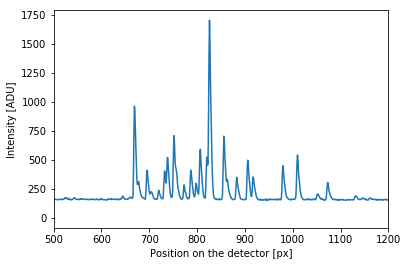

In [8]:
position, intensity = np.genfromtxt(data_dir + 'neon.txt', unpack = True, usecols = [0, 1], invalid_raise = False)


# When np.loadtxt() encounters a defective value (e.g. a string where a number is expected), it crashes.
# np.genfromtxt() with "invalid_raise=False" will run successfully, replacing the defective data with a
# special value called "nan" (for "not-a-number")
# We need to remove all nans from our data first.
# np.isnan() can be used to test if a value is a nan

faulty_mask = np.logical_or(np.isnan(position), np.isnan(intensity))  # Find all the faulty rows...

# ... and remove them
position = position[np.logical_not(faulty_mask)]
intensity = intensity[np.logical_not(faulty_mask)]

# Now plot the spectrum!
plt.plot(position, intensity)
plt.xlabel('Position on the detector [px]')
plt.ylabel('Intensity [ADU]')
plt.xlim(500, 1200)    # Limit the plot between 500 and 1200 pixels. Adjust those numbers to zoom or pan.
                       # How would you go about choosing these numbers automatically?

<div class="alert alert-warning">
<b>Warning:</b> In this notebook, I will only use a single exposure off the arc lamp to carry out the calibration. For your purposes, you must acquire every spectrum as many times as possible and average them all.
</div>

The spectrum shows a bunch of spectral lines that we can use to calibrate our detector. But first, we need our code to find them. Ideally, we need to automate the process as much as possible. We certainly do not want to enter the positions of the lines in the code manually.

In this notebook, I will be identifying emission lines as local maxima (i.e., pixels that have a higher intensity than other pixels in their immediate neighbourhood). There are many other ways of approaching this problem and you are welcome to use your imagination and come up with your own methods.

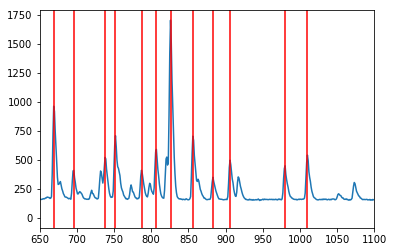

In [9]:
# We will iterate over every pixel and check if it is a local maxmum
local_maxima = []   # We will store the ones we find here

# We need to decide on how many pixels in the vicinity of a local maximum need to be smaller than it
# to be still considered a local maximum. Try changing this parameter until the best result is achieved
neighbourhood_size = 10

# Local maxima that are too small are more likely to be noise than actual spectral features. Hence, we want
# to establish a minimum intensity threshold, below which all maxima will be rejected. Once again, this is
# a free parameter that you should experiment with!
minimum_intensity = 0.2    # Set as a fraction of the maximum intensity

# The for-loop below can be rewritten as much more efficient loop-free operations on NumPy arrays
# using array slicing. Can you figure out how?

for i, value in enumerate(intensity):
    # We will assume that there are no emission lines at the edges of the spectrum. Even if there are,
    # we will not be able to see them in full and, so, they will not be of any use to us
    if (i < neighbourhood_size) or (i > len(intensity) - neighbourhood_size - 1):
        continue # Remember, continue breaks the iteration and jumps to the next one!
    
    # Reject features that are too faint
    if intensity[i] < max(intensity) * minimum_intensity:
        continue
    
    # Get all the neighbourhood pixels
    neighbourhood = intensity[i - neighbourhood_size : i + neighbourhood_size]
    neighbourhood = np.delete(neighbourhood, neighbourhood_size) # Exclude the pixel under examination itself
    if (max(neighbourhood) >= intensity[i]):
        continue # Not a local maximum
    
    # If we get here, we found a local maximum! Save it!
    local_maxima += [position[i]]

# Plot all found maxima out
plt.plot(position, intensity)
plt.xlim(650, 1100)
# Need axis labels!
for local_maximum in local_maxima:
    plt.axvline(local_maximum, color = 'r')   # plt.axvline() adds a vertical line to the plot at a given position

Now we have a rough idea of where the neon emission lines are on the detector. Some lines may have complex asymmetric shapes, while others may be distorted by noise. Therefore, the pixel with the largest count is not a good estimator of the true position of the line on the detector. Instead, we need to identify the edges of the emission profile of the line and find its centroid (average of pixel positions weighted by intensity) within those edges.

How do we know where line profiles begin and end? The standard definition of the profile edges commonly used in spectroscopy is where the intensity of the line drops to a half of its maximum value. We will use this definition to find the left and the right edges of each emission line saved in `local_maxima`. The width of the line defined in this way is known as the *Full-Width-at-Half-Maximum* or, more commonly, *FWHM*.

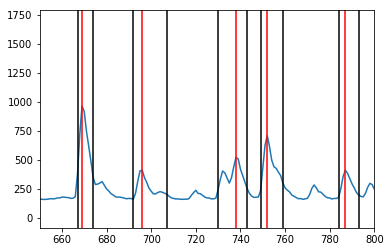

In [10]:
left_edges = []
right_edges = []

for i, local_maximum in enumerate(local_maxima):
    maximum_intensity = intensity[position == local_maximum]
    half_intensity = maximum_intensity / 2.0
    
    # Find all pixels with intensities less than half-maximum. Those pixels, by definition
    # do not belong to our line
    outside_pixels = intensity < half_intensity
    
    # The left and the right edges of the line profile will simply be the closest outside pixels
    # to the left and to the right of the maximum
    left_edge  = max(position[(position < local_maximum) & outside_pixels])
    right_edge = min(position[(position > local_maximum) & outside_pixels])
    
    left_edges += [left_edge]
    right_edges += [right_edge]

# Plot both edges to make sure the code works
plt.plot(position, intensity)
plt.xlim(650, 800)
# Needs axis labels and a legend!
for i, local_maximum in enumerate(local_maxima):
    plt.axvline(local_maximum, color = 'r')
    plt.axvline(left_edges[i], color = 'k')
    plt.axvline(right_edges[i], color = 'k')

Now that the edges of each profile are known, it is easy to find the centroids of each line.

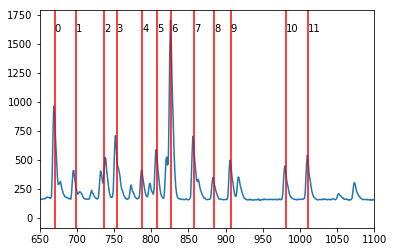

In [11]:
# Due to the complexity some of the line profiles may have, our identification of edges may
# fail for some of them. A good indicator of that is lines that are too wide. It is a good idea
# to set a maximum threshold on how wide a line can be and reject everything that does not fit.
max_width = 50

centroids = []

for i, local_maximum in enumerate(local_maxima):
    # Check line FWHM
    if right_edges[i] - left_edges[i] > max_width:
        continue # Probably an erroneous identification
    
    inside_pixels = (position >= left_edges[i]) & (position <= right_edges[i])
    centroid = np.sum(position[inside_pixels] * intensity[inside_pixels]) / np.sum(intensity[inside_pixels])
    centroids += [centroid]

plt.plot(position, intensity)
plt.xlim(650, 1100)
for i, centroid in enumerate(centroids):
    plt.axvline(centroid, color = 'r')
    plt.text(centroid, 1600, str(i))  # Also write out the serial number of the line

<br>
<div class="alert alert-warning">
<b>Warning:</b> The method I suggest above is very basic and will not work for every spectrum. You are expected to carefully consider every step and implement necessary improvements. It is also recommended to discuss any issues in your report.
<ul>
  <li>Is there a better way to distinguish between local maxima due to lines and local maxima due to noise than through an intensity threshold?</li>
  <li>Some lines will have overlapping emission profiles, resulting in multiple local maxima per line. How do we identify and handle those?</li>
  <li>Are half-maximum points a reliable way of telling where the line begins and ends? Can it be improved?</li>
  <li>Are half-maximum points actually at half-maximum? What about the bias of the detector? How do we estimate it and account for it?</li>
  <li>Do we need the user to set the free parameters (such as the intensity threshold, the neighbourhood size and the maximum line width) or can they be reasonably determined in the code itself?</li>
</ul>
</div>
<br>

With pixel positions of each line known, it is time to match them to their known wavelengths. The example dataset contains a PNG diagram of the annotated neon spectrum. The code cell below merely displays it. If the image does not show up, make sure the `url` argument of `Image()` is set in accordance with your file structure.

In [12]:
from IPython.display import Image
Image(url= data_dir + "neon-spectrum.png")

Hopefully, some similarities are apparent between the reference spectrum and the spectrum we obtained from the data file. Only two lines are necessary to obtain a very crude wavelength calibration. I will use lines <b>0</b> and <b>3</b> (from the example dataset) to do so:

<br>
<div class="alert alert-warning">
    <b>Warning:</b> I use built-in fitting routines (specifically, <code>np.polyfit()</code>) in this notebook. You are not allowed to use these routines in your own code and are expected to implement your own fitting algorithm. Some of the fundamental techniques behind those will be covered later in the course.
</div>

In [13]:
pixel_positions = [centroids[0], centroids[3]]
wavelengths = [585.24879, 614.30626]   # From the diagram; converting to nm
crude_calib = np.polyfit(pixel_positions, wavelengths, 1)

Now we can use this crude calibration to find crude wavelengths of the other lines, which we can then use to find the actual wavelengths from the reference spectrum.

Text(0,0.5,'Refined wavelengths [nm]')

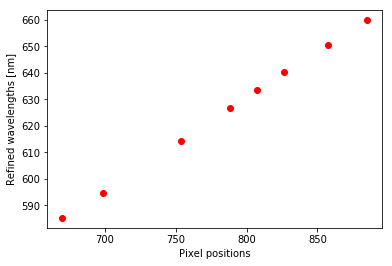

In [14]:
# Rough estimate of the accuracy of the crude calibration (in nm).
# This value should be of order 1 nm or so
crude_accuracy = 1

# Lines from the standard spectrum (the diagram), in nm
all_known_lines = np.array([585.24879, 588.18952, 594.48342, 597.5534, 602.99969, 614.30626,
                   616.35939, 621.72812, 626.6495, 633.44278, 638.29917, 640.2248, 650.65281, 659.89529])

pixel_positions = np.array(centroids)
crude_wavelengths = crude_calib[0] * pixel_positions + crude_calib[1]  # Could use np.poly1d() instead!


refined_wavelengths = np.zeros(len(pixel_positions))    # Refined wavelengths to be stored here


# Now we iterate over all crude wavelengths and refine each one using the reference spectrum
for i, crude_wavelength in enumerate(crude_wavelengths):
    # Find the closest standard wavelength to our crude wavelength
    distances = np.abs(crude_wavelength - all_known_lines)
    min_distance = np.min(distances)
    
    # If there are no reference lines within the crude accuracy limit, there likely isn't a reference
    # wavelength for this line. Not much we can do :( (unless you find a different reference, of course)
    if np.abs(min_distance) > crude_accuracy:
        continue
    
    refined_wavelengths[i] = all_known_lines[distances == min_distance]

# Remove all lines that have no standard wavelengths (they will remain zeros)
pixel_positions = pixel_positions[refined_wavelengths != 0]
refined_wavelengths = refined_wavelengths[refined_wavelengths != 0]

# Plot wavelengths against pixel positions
plt.plot(pixel_positions, refined_wavelengths, 'ro')
plt.xlabel("Pixel positions")
plt.ylabel("Refined wavelengths [nm]")

With precise wavelengths for most of the identified lines, a much better wavelength calibration can be established. We may want to save it in a file for future use.

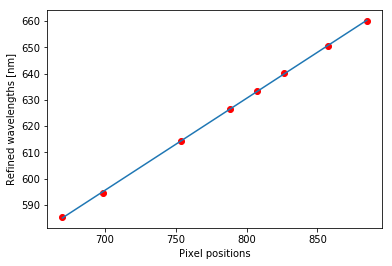

In [15]:
refined_calib = np.polyfit(pixel_positions, refined_wavelengths, 1)

# Plot the polynomial
plt.plot(pixel_positions, refined_wavelengths, 'ro')
plt.xlabel("Pixel positions")
plt.ylabel("Refined wavelengths [nm]")
x = np.linspace(min(pixel_positions), max(pixel_positions), 1000)
y = np.poly1d(refined_calib)(x)
plt.plot(x, y)

# Save the calibration in a file
np.savetxt(data_dir + 'calibration.dat', refined_calib)

# Import the relevant functions from SciPy
from scipy.odr import Model, Data, ODR

# SciPy requires our model to be defined as a Python function
def model(best_fit, x):
    return (best_fit[0] * refined_wavelengths) + best_fit[1]

**Important:** sodium emission lines only cover an extremely narrow range of wavelengths, compared to the range of the detector. This means that you will have to combine those lines with ones you will need to extract from other reference spectra, such as the helium arc lamp or the fluorescent light. The procedure should however be very similar.

## Sky spectrum

We will now test-drive our fresh wavelength calibration by plotting out the spectrum of the daylight sky obtained with the Ocean Optics spectrometer.

C:\Users\Roman\Anaconda\lib\site-packages\ipykernel_launcher.py:3: ConversionWarning: Some errors were detected !
    Line #2 (got 1 columns instead of 2)
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Intensity [ADU]')

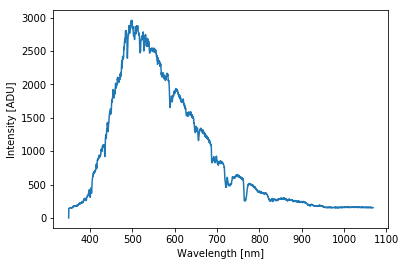

In [16]:
# Load the sky spectrum just like we loaded neon before

position, intensity = np.genfromtxt(data_dir + 'sky.txt', unpack = True, usecols = [0, 1], invalid_raise = False)
faulty_mask = np.logical_or(np.isnan(position), np.isnan(intensity))  # Find all the faulty rows...
position = position[np.logical_not(faulty_mask)]
intensity = intensity[np.logical_not(faulty_mask)]

# Now apply our wavelength calibration

calib = np.loadtxt(data_dir + 'calibration.dat')
wavelengths = np.poly1d(calib)(position)

plt.plot(wavelengths, intensity)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity [ADU]')